# Introduction

In the following notebook, I will be modeling Airbnb Listings data to create a price predictor to better understand the data

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

**Set notebook preferences**

In [69]:
#Set options for pandas
pd.set_option('display.max_columns',1_000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Set options for numpy
np.set_printoptions(suppress=True)

#Set Visualization preferences
plt.style.use('fivethirtyeight')
print(plt.style.available)

#Surpress warnings
import warnings
warnings.simplefilter('ignore')

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


**Read in data**

In [3]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\03_Processed'

#Read in training data and labels
df = pd.read_csv(path + '/2020_0608_Listings_Processed.csv', index_col=0)

**Data Overview**

In [4]:
#Display data and shape
print('Data shape: {}\n'.format(df.shape))
display(df.head())

Data shape: (113976, 612)



,24-hour_check-in,accessible-height_bed,accessible-height_toilet,accommodates,air_conditioning,air_purifier,alarm_system,amazon_echo,amenities_count,apple_tv,availability_30,availability_365,availability_60,availability_90,baby_bath,baby_monitor,babysitter_recommendations,baking_sheet,balcony,barbecue_utensils,bath_towel,bathroom_essentials,bathrooms,bathtub,bathtub_with_bath_chair,bbq_grill,beach_essentials,beach_view,beachfront,bed_linens,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bedroom_comforts,bedrooms,beds,bidet,body_soap,bread_maker,breakfast,breakfast_bar,breakfast_table,building_staff,buzzer/wireless_intercom,cable_tv,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,cancellation_policy_flexible,cancellation_policy_luxury moderate,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict 14 with grace period,cancellation_policy_super strict 30,cancellation_policy_super strict 60,carbon_monoxide_detector,cat(s),ceiling_fan,central_air_conditioning,changing_table,chef_s_kitchen,children’s_books_and_toys,children’s_dinnerware,city_Daly City,city_San Francisco,city_San Jose,city_South San Francisco,cleaning_before_checkout,cleaning_fee,coffee_maker,convection_oven,cooking_basics,courtyard,crib,day_bed,desk,dining_area,disabled_parking_spot,dishes_and_silverware,dishwasher,dog(s),doorman,double_oven,driveway_parking,dryer,dual_vanity,dvd_player,electric_profiling_bed,elevator,email,en_suite_bathroom,espresso_machine,essentials,ethernet_connection,ev_charger,exercise_equipment,extra_people,extra_pillows_and_blankets,extra_space_around_bed,extra_space_around_shower_and_toilet,facebook,family/kid_friendly,fax_machine,fire_extinguisher,fire_pit,fireplace_guards,firm_mattress,first_aid_kit,first_review_month_April,first_review_month_August,first_review_month_December,first_review_month_February,first_review_month_January,first_review_month_July,first_review_month_June,first_review_month_March,first_review_month_May,first_review_month_November,first_review_month_October,first_review_month_September,first_review_weekday_Friday,first_review_weekday_Monday,first_review_weekday_Saturday,first_review_weekday_Sunday,first_review_weekday_Thursday,first_review_weekday_Tuesday,first_review_weekday_Wednesday,first_review_year_2009.0,first_review_year_2010.0,first_review_year_2011.0,first_review_year_2012.0,first_review_year_2013.0,first_review_year_2014.0,first_review_year_2015.0,first_review_year_2016.0,first_review_year_2017.0,first_review_year_2018.0,first_review_year_2019.0,first_review_year_2020.0,fixed_grab_bars_for_shower,fixed_grab_bars_for_toilet,flat_path_to_front_door,flat_path_to_guest_entrance,formal_dining_area,free_parking_on_premises,free_street_parking,full_kitchen,game_console,garage_parking,garden_or_backyard,gas_fireplace,gas_oven,google,government_id,ground_floor_access,guests_included,gym,hair_dryer,hammock,handheld_shower_head,hangers,hbo_go,heat_lamps,heated_floors,heated_towel_rack,heating,high-resolution_computer_monitor,high_chair,home_theater,host_greets_you,host_has_profile_pic,host_identity_verified,host_is_superhost,host_listings_count,host_response_rate,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_since_month_April,host_since_month_August,host_since_month_December,host_since_month_February,host_since_month_January,host_since_month_July,host_since_month_June,host_since_month_March,host_since_month_May,host_since_month_November,host_since_month_October,host_since_month_September,host_since_weekday_Friday,host_since_weekday_Monday,host_since_weekday_Saturday,host_since_weekday_Sunday,host_since_weekday_Thursday,host_since_weekday_Tuesday,host_since_weekday_Wednesday,host_since_year_2008.0,host_since_year_2009.0,host_since_year_2010.0,host_since_year_2011.0,host_since_year_

### Data Preparation

**Split data into training and test sets**

In [5]:
#Seperate labels from data
X = df.drop('price', axis = 1)
y = df['price']

#Check
print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

X shape:(113976, 611)
y shape:(113976,)


In [7]:
#Import splitter
from sklearn.model_selection import train_test_split

#Split Data
X_train, X_test, y_train, y_test =  train_test_split(
                                    X,y, test_size = .30, random_state = 42)

#Check
print('Training data:{} | Training labels:{}'.format(X_train.shape,y_train.shape))
print('Test data:{} | Test labels:{}'.format(X_test.shape,y_test.shape))

Training data:(79783, 611) | Training labels:(79783,)
Test data:(34193, 611) | Test labels:(34193,)


# Feature Selection

## Univariate Feature Selection

In [ ]:
#Delete if not needed

## Supervised Learning Feature Selection

**Select features using DecisionTreeRegressor

In [66]:
#Read in SelectFromModel 
from sklearn.feature_selection import SelectFromModel

#Read in models for feature selection
from sklearn.tree import DecisionTreeRegressor

#Init SelectFromModel
selector = SelectFromModel(estimator=DecisionTreeRegressor(max_depth=10, random_state=42), 
                                threshold='1.25 * mean', prefit=False).fit(X_train, y_train)

#Create dataframe storing features and their respective performance from selector
selector_feat_importance = pd.DataFrame(selector.estimator_.feature_importances_,index=X_train.columns)
selector_feat_importance.columns = ['feature_importance']


#Get list of features selector kept
feats = X_train.columns[selector.get_support()].tolist()

#Subset selector_feat_importance
selector_feat_importance = selector_feat_importance[selector_feat_importance.index.isin(feats)].sort_values(by = 'feature_importance', ascending=False)

#Check
display(selector_feat_importance.head())

**Display Feature Importance**

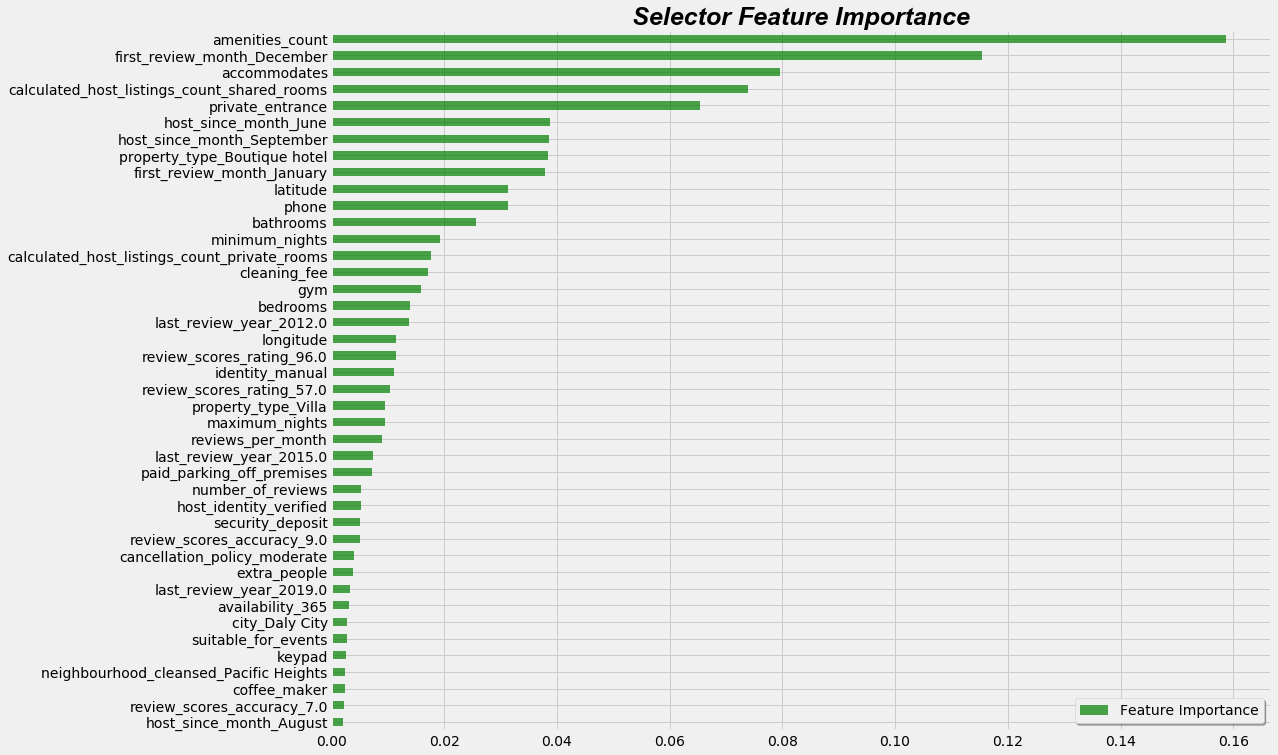

In [85]:
#Set figure
f, ax = plt.subplots(figsize = (15,12))

#Plot data
selector_feat_importance.plot(kind = 'barh', ax = ax, color = 'green', alpha = .7)

###Set Plot Aesthetics###
#Title
ax.set_title('Selector Feature Importance', fontsize = 25, fontweight = 'semibold', style = 'italic', fontname="Arial")

#Axes
ax.invert_yaxis()

#Legend
ax.legend(['Feature Importance'],frameon = True, shadow = True);

## Machine Learning

### Base model pipeline development

**Objective: Select best base model to optimize and deploy on test data**

*Models to try:*
- Ensemble methods
- XGBoost

**Read in libraries**

In [ ]:
#Import Pipeline and CV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

#Import ensemble methods 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,ExtraTreesRegressor

#Import XGB
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

#Import metrics 
from Regression_Metrics import regression_metrics

#Import progress bar
from tqdm import tqdm

**Initialize pipeline components**

In [ ]:
#Init models to to fit into pipeline
models = [
    RandomForestRegressor( n_jobs=-1),
    #GradientBoostingRegressor( n_jobs=-1),
#     AdaBoostRegressor(),
#     ExtraTreesRegressor(),
#     XGBRegressor()
]

# #Set parameters for models
# params = {
#     'RandomForestRegressor': {},
#     'GradientBoostingRegressor': {},
#     'AdaBoostRegressor': {},
#     'ExtraTreesRegressor': {},
#     'xgb': {},
# }

**Build preliminary pipeline, evaluate results, and select model for futher development**

In [ ]:
#Implement pipe for all regressors 
for model in tqdm(models):

#for model in models:
    pipe = Pipeline([('model', model)], verbose=True)
    scores = cross_validate(pipe, X_train, y_train,cv = 3, n_jobs=-1)
    print(pipe['model'])
#    

Tune Hyperparameters

Preprocess Data

Build Deep Learning Model